## Variables Used

In [43]:
# Variables global to simulation
adjustment_window = 4000 # Number of prime blocks the difficulty is averaged over
num_blocks = 10000 # Total duration of simulation

# Variables related to difficulty
starting_difficulty = 100000000 # starting difficulty of the blockchain
difficulty_growth_factor = 0.0001 # rate at which the difficulty reacts to k_quai change, it doesnt have a memory element yet

# Variables related to k quai
start_k_quai = 1e9 # starting k quai value
k_quai_alpha = 1/1000 # Alpha value of the k quai controller

## Variables realted to the qi percentage chosen
target_qi_percentage = 500 # In basis points (5% = 500)
chosen_qi_percentage = 0 # Default percentage of speculators and miners chosing qi
qi_choice_alpha = 1/5000 # Alpha value of the adjustment to diff* based on the percentage qi choices

# Variables related to the quai and Qi choices, slip here is the price premium
# speculators are paying to convert
quai_choices = 2000
qi_choices = 2000
slip = 0.1 # 10% slip converting quai to qi 
slip_alpha = 1/5

# Scenario A

## No one is chosing Qi and speculators are indifferent between quai and qi, k quai will go down




In [44]:
import numpy as np

block_difficulties = [starting_difficulty]

qi_percentage_series = [chosen_qi_percentage] * num_blocks

# Initialize d (ema of average block difficulty)
d_ema = block_difficulties[0]

# Calculate d* (target difficulty, simple average of first 4000 observations)
d_star = np.mean(block_difficulties[:adjustment_window])

# Store k_quai evolution
k_quai_series = [start_k_quai]
d_ema_series = [d_ema]
d_star_series = [d_star]
qi_percentage = 0

for n in range(0, num_blocks-1):
    # Update d_ema (ema of average block difficulty)
    d_ema = ((adjustment_window-1) * d_ema + block_difficulties[n]) / adjustment_window
    d_ema_series.append(d_ema)

    # Update d* as the simple average of the last 4000 d_ema values (rolling window)
    if n >= adjustment_window:
        d_star = np.mean(d_ema_series[n-adjustment_window+1:n+1])
    else:
        d_star = np.mean(d_ema_series[:n+1])

    # update d_star based on qi_percentage
    if qi_percentage_series[n] > target_qi_percentage:
        d_star += qi_choice_alpha  * (qi_percentage_series[n] - target_qi_percentage) * d_star
    else:
        d_star -= qi_choice_alpha * (target_qi_percentage - qi_percentage_series[n]) * d_star

    # update the d_star based on the realized and actual amount of conversion value
    # lets also assume the realized amount is 0.95 of the actual amount
    # it depends on the number of quai and qi choices

    if quai_choices > qi_choices:
        d_star -= slip_alpha * (slip * d_star)
    elif quai_choices< qi_choices:
        d_star += slip_alpha * (slip * d_star)

    d_star_series.append(d_star)

    # k_quai update formula
    k_quai_new = k_quai_series[-1] + k_quai_series[-1] * k_quai_alpha * (d_star/d_ema - 1)

    # Adding a decay
    k_quai_new = 0.9999 * k_quai_new

    k_quai_series.append(k_quai_new)


    # TODO: make this proportional to the difference between k_quai_series[-1] and k_quai_series[-2]
    # assumption here is that difficulty responds to the change in k_quai in the next block
    if k_quai_series[-1] > k_quai_series[-2]:
        # Increase the difficulty by a small percentage (e.g., 1%)
        new_difficulty = block_difficulties[-1] * (1+difficulty_growth_factor)
        block_difficulties.append(new_difficulty)
    else:
        # Keep the difficulty the same
        new_difficulty = block_difficulties[-1] * (1-difficulty_growth_factor)
        block_difficulties.append(new_difficulty)


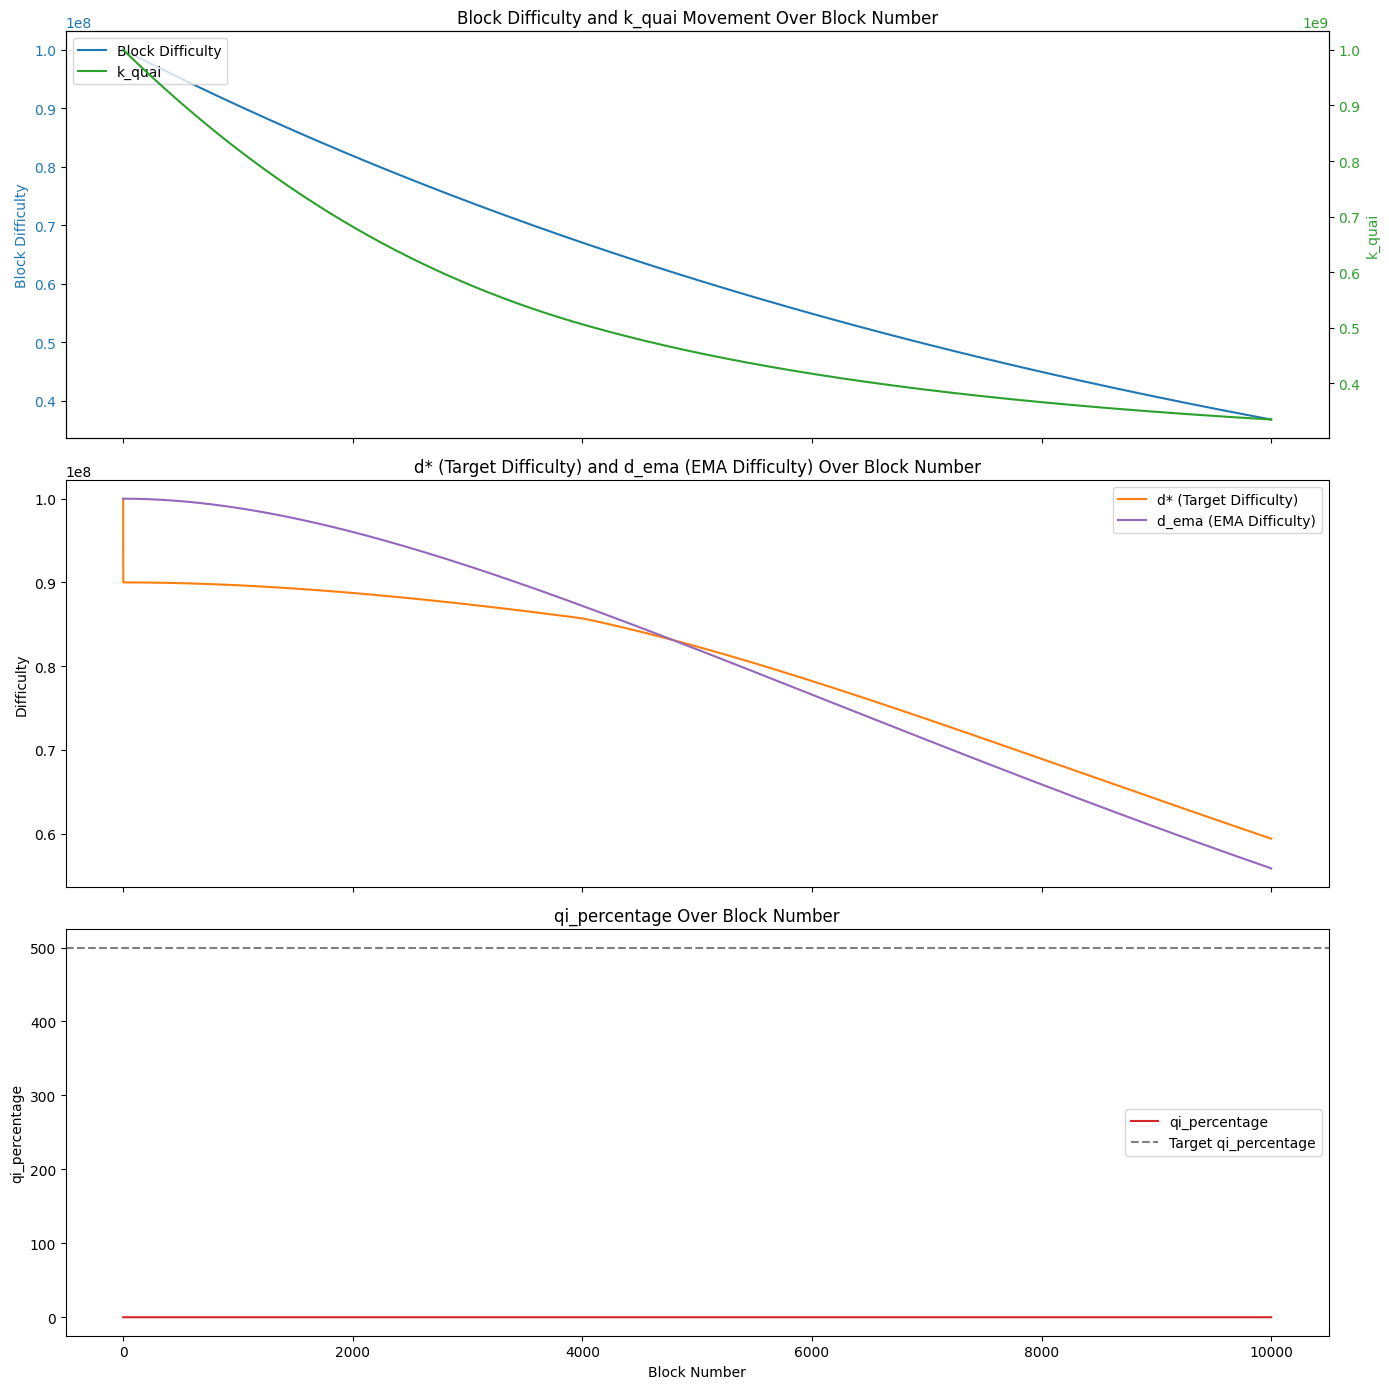

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

block_numbers = list(range(num_blocks))

# Plot 1: Block Difficulty and k_quai
color1 = 'tab:blue'
color2 = 'tab:green'
ax1 = axs[0]
lns1 = ax1.plot(block_numbers, block_difficulties, color=color1, label='Block Difficulty')
ax1.set_ylabel('Block Difficulty', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')
ax1b = ax1.twinx()
lns2 = ax1b.plot(block_numbers, k_quai_series, color=color2, label='k_quai')
ax1b.set_ylabel('k_quai', color=color2)
ax1b.tick_params(axis='y', labelcolor=color2)
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')
ax1.set_title('Block Difficulty and k_quai Movement Over Block Number')

# Plot 2: d* and d_ema
block_numbers_d = list(range(len(d_star_series)))
ax2 = axs[1]
ax2.plot(block_numbers_d, d_star_series, label='d* (Target Difficulty)', color='tab:orange')
ax2.plot(block_numbers_d, d_ema_series, label='d_ema (EMA Difficulty)', color='tab:purple')
ax2.set_ylabel('Difficulty')
ax2.set_title('d* (Target Difficulty) and d_ema (EMA Difficulty) Over Block Number')
ax2.legend()

# Plot 3: qi_percentage_series
block_numbers_qi = list(range(len(qi_percentage_series)))
ax3 = axs[2]
ax3.plot(block_numbers_qi, qi_percentage_series, label='qi_percentage', color='tab:red')
ax3.axhline(y=target_qi_percentage, color='tab:gray', linestyle='--', label='Target qi_percentage')
ax3.set_xlabel('Block Number')
ax3.set_ylabel('qi_percentage')
ax3.set_title('qi_percentage Over Block Number')
ax3.legend()

plt.tight_layout()
plt.show()




In [ ]:
# Print the initial and final k_quai for comparison
print("Initial k_quai:", k_quai_series[0], "Final k_quai:", k_quai_series[-1])
print("Final d* (target difficulty):", d_star_series[-1])
print("Initial d_ema:", d_ema_series[0], "Final d_ema:", d_ema_series[-1])

# percentage change in k_quai
percentage_change = (k_quai_series[-1] - k_quai_series[0])  * 100 / k_quai_series[0]
print("Percentage change in k_quai:", percentage_change)

import math
initial_emission = start_k_quai * math.log2(starting_difficulty)
final_emission = k_quai_series[-1] * math.log2(block_difficulties[-1])
print("Initial emission per block", initial_emission, "Final emission per block", final_emission)
print("Percentage of the initial emission", (initial_emission-final_emission)/initial_emission)



Initial k_quai: 1000000000.0 Final k_quai: 335063609.8733995
Final d* (target difficulty): 59393228.01376925
Initial d_ema: 100000000 Final d_ema: 55844314.91866638
Percentage change in k_quai: -66.49363901266005
Initial emission per block 26575424759.098896 Final emission per block 8421087315.8920555
